In [1]:
!pip install keras-tcn
!pip install keras-tcn --no-dependencies

In [2]:
import math
import matplotlib.pyplot as plt
import numpy as np

import keras 
import pandas as pd


from keras.models import Sequential
from keras.layers import Dense 

from keras.layers import Dropout

from keras.layers import LSTM

from keras.layers import *


from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import mean_squared_error

from sklearn.metrics import mean_absolute_error

from sklearn.model_selection import train_test_split

from keras.callbacks import EarlyStopping


from keras.layers import Dense, InputLayer, Dropout, Flatten, BatchNormalization, Conv1D



from keras.layers import Dense, Embedding, LSTM, Bidirectional

from tcn import TCN, tcn_full_summary

DATA

In [3]:
df=pd.read_csv("MSFT.csv")
print("Number of rows and columns:", df.shape)
df.head(5)
training_set = df.iloc[:1052, 4:5].values

test_set = df.iloc[1052:, 4:5].values
# Feature Scaling
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)
# Creating a data structure with 60 time-steps and 1 output
X_train = []
y_train = []
for i in range(60, 1052):
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0],  X_train.shape[1], 1, 1))
X_train.shape

Number of rows and columns: (1503, 7)


(992, 60, 1, 1)

TCN Model

In [4]:
dataset_train = df.iloc[:1052, 4:5]
dataset_test = df.iloc[1052:, 4:5]
dataset_total = pd.concat((dataset_train, dataset_test), axis = 0)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 60:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
print(inputs.shape)
X_test = []
for i in range(60, 511):
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
print(X_test.shape)

y =  dataset_test.values.reshape(451,) 
# (459, 60, 1)

(511, 1)
(451, 60, 1)


In [5]:
np.random.seed(1)
model = Sequential()
model.add(TCN(nb_filters=64, kernel_size=5, nb_stacks=1, dilations=[1, 2, 4, 8, 16 ], padding='causal', use_skip_connections=False, dropout_rate=0.1, return_sequences=False, activation='relu', input_shape = (X_train.shape[1], 1)))
#model.add(Dropout(0.1))
model.add(Dense(units = 1))
model.compile(optimizer = 'adam', loss = 'mean_squared_error')
model.fit(X_train, y_train, epochs = 50, batch_size = 32)

Epoch 1/50
31/31 [==============================] - 4s 15ms/step - loss: 4.6188
Epoch 2/50
31/31 [==============================] - 0s 12ms/step - loss: 0.2894
Epoch 3/50
31/31 [==============================] - 0s 12ms/step - loss: 0.1350
Epoch 4/50
31/31 [==============================] - 0s 12ms/step - loss: 0.0944
Epoch 5/50
31/31 [==============================] - 0s 12ms/step - loss: 0.0794
Epoch 6/50
31/31 [==============================] - 0s 12ms/step - loss: 0.0553
Epoch 7/50
31/31 [==============================] - 0s 13ms/step - loss: 0.0487
Epoch 8/50
31/31 [==============================] - 0s 13ms/step - loss: 0.0368
Epoch 9/50
31/31 [==============================] - 0s 13ms/step - loss: 0.0286
Epoch 10/50
31/31 [==============================] - 0s 16ms/step - loss: 0.0254
Epoch 11/50
31/31 [==============================] - 1s 17ms/step - loss: 0.0188
Epoch 12/50
31/31 [==============================] - 0s 13ms/step - loss: 0.0165
Epoch 13/50
31/31 [==================

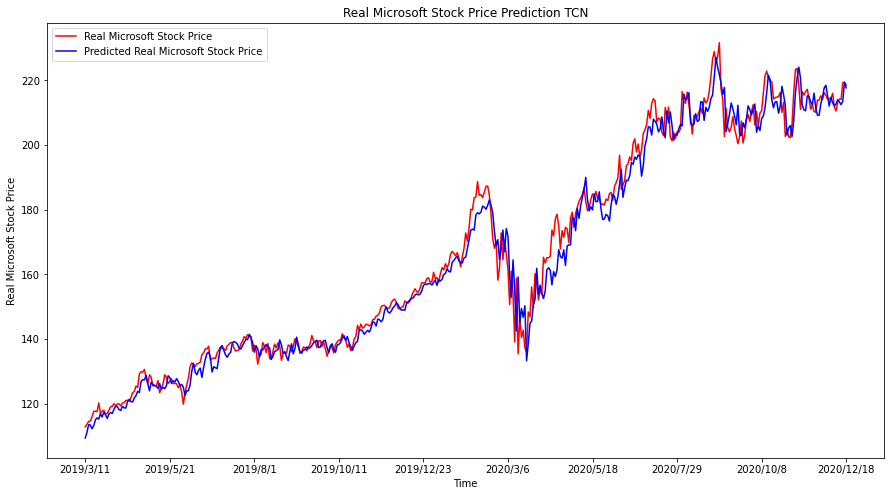

In [6]:
predicted_stock_price = model.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)
y =  dataset_test.values.reshape(451,) 
x = df.loc[1052: , "Date"] 
# Visualising the results
plt.figure(figsize=(15,8))
plt.plot(x, y, c= "red", label = "Real Microsoft Stock Price")
plt.plot(df.loc[1052:, "Date"],predicted_stock_price, color = "blue", label = "Predicted Real Microsoft Stock Price")
plt.xticks(np.arange(0,451,50))
plt.title('Real Microsoft Stock Price Prediction TCN')
plt.xlabel('Time')
plt.ylabel('Real Microsoft Stock Price')
plt.legend()
plt.savefig("Real Microsoft TCN")
plt.show() 

In [7]:
abse = mean_absolute_error(predicted_stock_price,y)
abse

3.2855595741786914

In [8]:
rmse = math.sqrt(mean_squared_error(predicted_stock_price,y))
rmse

4.616814049117507

TCN + GRU model

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 60, 1)]      0           []                               
                                                                                                  
 gru (GRU)                      (None, 200)          121800      ['input_1[0][0]']                
                                                                                                  
 tcn_1 (TCN)                    (None, 64)           185408      ['input_1[0][0]']                
                                                                                                  
 dense_1 (Dense)                (None, 1)            201         ['gru[0][0]']                    
                                                                                              

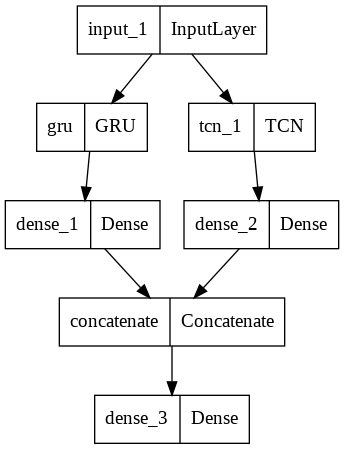

In [9]:
np.random.seed(1)


from keras.layers import Input
#from keras.utils import plot_model
from keras.utils.vis_utils import plot_model
from keras.layers.merge import concatenate
from keras.models import Model

visible = Input(shape=(60,1))

#GRU
gru1 = GRU(units = 200, input_shape = (X_train.shape[1], 1))(visible)
out1 = Dense(units = 1)(gru1)

#TCN
tcn1 = TCN(nb_filters=64, kernel_size=5, nb_stacks=1, dilations=[1, 2, 4, 8, 16 ], padding='causal', use_skip_connections=False, dropout_rate=0, return_sequences=False, activation='relu', input_shape = (X_train.shape[1], 1))(visible)
out2 = Dense(units = 1)(tcn1)

# merge interpretation
merge = concatenate([out1, out2])

# output
output = Dense(1)(merge)
model = Model(inputs=visible, outputs=output)

# summarize layers
print(model.summary())

# plot graph
plot_model(model, to_file='shared_feature_extractor-microsoft.png')

In [10]:
model.compile(optimizer = 'adam', loss = 'mean_squared_error')
model.fit(X_train, y_train, epochs = 30, batch_size = 32)

Epoch 1/30
31/31 [==============================] - 3s 11ms/step - loss: 3.0173
Epoch 2/30
31/31 [==============================] - 0s 11ms/step - loss: 0.0102
Epoch 3/30
31/31 [==============================] - 0s 12ms/step - loss: 0.0022
Epoch 4/30
31/31 [==============================] - 0s 11ms/step - loss: 0.0014
Epoch 5/30
31/31 [==============================] - 0s 11ms/step - loss: 0.0014
Epoch 6/30
31/31 [==============================] - 0s 12ms/step - loss: 0.0015
Epoch 7/30
31/31 [==============================] - 0s 11ms/step - loss: 0.0012
Epoch 8/30
31/31 [==============================] - 0s 11ms/step - loss: 9.9203e-04
Epoch 9/30
31/31 [==============================] - 0s 12ms/step - loss: 0.0011
Epoch 10/30
31/31 [==============================] - 0s 11ms/step - loss: 0.0021
Epoch 11/30
31/31 [==============================] - 0s 11ms/step - loss: 0.0014
Epoch 12/30
31/31 [==============================] - 0s 11ms/step - loss: 0.0011
Epoch 13/30
31/31 [==============

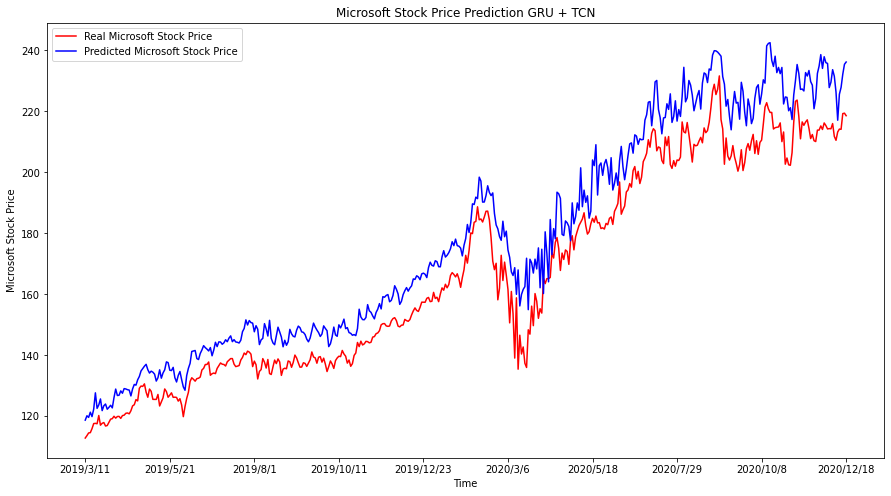

In [11]:
predicted_stock_price = model.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)
y =  dataset_test.values.reshape(451,) 
x = df.loc[1052: , "Date"] 
# Visualising the results
plt.figure(figsize=(15,8))
plt.plot(x, y, c= "red", label = "Real Microsoft Stock Price")
plt.plot(df.loc[1052:, "Date"],predicted_stock_price, color = "blue", label = "Predicted Microsoft Stock Price")
plt.xticks(np.arange(0,451,50))
plt.title('Microsoft Stock Price Prediction GRU + TCN')
plt.xlabel('Time')
plt.ylabel('Microsoft Stock Price')
plt.legend() 
plt.savefig("Microsoft GRU + TCN")
plt.show()

In [12]:
abse = mean_absolute_error(predicted_stock_price,y)
rmse = math.sqrt(mean_squared_error(predicted_stock_price,y))
print(abse, rmse)

11.28086373331832 12.550910231148523


CNN LSTM MODEL

In [13]:

dataset_train = df.iloc[:1052, 4:5]
dataset_test = df.iloc[1052:, 4:5]
dataset_total = pd.concat((dataset_train, dataset_test), axis = 0)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 60:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
print(inputs.shape)
X_test = []
for i in range(60, 511):
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1, 1))
print(X_test.shape)

y =  dataset_test.values.reshape(451,) 
# (459, 60, 1)

(511, 1)
(451, 60, 1, 1)


In [14]:
np.random.seed(1)

model = Sequential()

model.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'), input_shape = (X_train.shape[1],1, 1)))

model.add(TimeDistributed(MaxPooling1D(pool_size=1)))

model.add(TimeDistributed(Flatten()))

model.add(GRU(units = 700)) #, return_sequences = True

model.add(Dropout(0.1))


model.add(Dense(units = 1))


model.compile(optimizer = 'adam', loss = 'mean_squared_error')


model.fit(X_train, y_train, epochs = 50, batch_size = 32)

Epoch 1/50
31/31 [==============================] - 2s 15ms/step - loss: 0.0149
Epoch 2/50
31/31 [==============================] - 0s 15ms/step - loss: 6.1642e-04
Epoch 3/50
31/31 [==============================] - 0s 15ms/step - loss: 3.6740e-04
Epoch 4/50
31/31 [==============================] - 0s 14ms/step - loss: 3.8751e-04
Epoch 5/50
31/31 [==============================] - 0s 15ms/step - loss: 3.5024e-04
Epoch 6/50
31/31 [==============================] - 0s 14ms/step - loss: 3.6138e-04
Epoch 7/50
31/31 [==============================] - 0s 15ms/step - loss: 3.8093e-04
Epoch 8/50
31/31 [==============================] - 0s 14ms/step - loss: 3.3466e-04
Epoch 9/50
31/31 [==============================] - 0s 15ms/step - loss: 3.7283e-04
Epoch 10/50
31/31 [==============================] - 0s 14ms/step - loss: 3.5239e-04
Epoch 11/50
31/31 [==============================] - 0s 15ms/step - loss: 3.8519e-04
Epoch 12/50
31/31 [==============================] - 0s 14ms/step - loss: 3.67

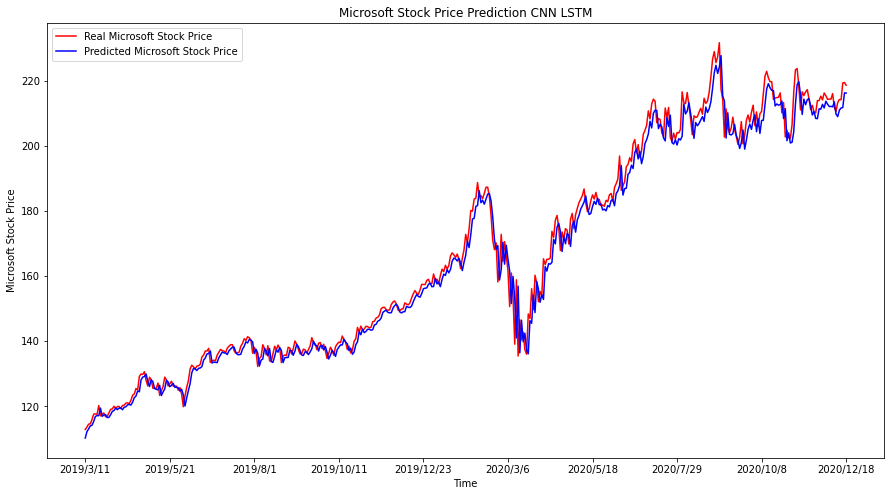

In [15]:
predicted_stock_price = model.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)
y =  dataset_test.values.reshape(451,) 
x = df.loc[1052: , "Date"] 
# Visualising the results
plt.figure(figsize=(15,8))
plt.plot(x, y, c= "red", label = "Real Microsoft Stock Price")
plt.plot(df.loc[1052:, "Date"],predicted_stock_price, color = "blue", label = "Predicted Microsoft Stock Price")
plt.xticks(np.arange(0,451,50))
plt.title('Microsoft Stock Price Prediction CNN LSTM')
plt.xlabel('Time')
plt.ylabel('Microsoft Stock Price')
plt.legend()
plt.savefig("Microsoft CNN LSTM")
plt.show() 

In [16]:
abse = mean_absolute_error(predicted_stock_price,y)
abse

2.8513220577655125

In [17]:
rmse = math.sqrt(mean_squared_error(predicted_stock_price,y))
rmse

4.000350770873629

CNN

In [18]:
df=pd.read_csv("MSFT.csv")
print("Number of rows and columns:", df.shape)
df.head(5)
training_set = df.iloc[:1052, 4:5].values

test_set = df.iloc[1052:, 4:5].values
# Feature Scaling
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)
# Creating a data structure with 60 time-steps and 1 output
X_train = []
y_train = []
for i in range(60, 1052):
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1], 1))
X_train.shape

Number of rows and columns: (1503, 7)


(992, 1, 60, 1)

In [19]:
np.random.seed(1)

model = Sequential()

model.add(TimeDistributed(Conv1D(filters=128, kernel_size=11, activation='relu'), input_shape = (1, X_train.shape[2],1)))
print(model.output_shape)
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
print(model.output_shape)
model.add(TimeDistributed(Flatten()))
print(model.output_shape)


model.add(Dense(units = 1))
print(model.output_shape)

model.compile(optimizer = 'adam', loss = 'mean_squared_error')


model.fit(X_train, y_train, epochs = 30, batch_size = 32)

(None, 1, 50, 128)
(None, 1, 25, 128)
(None, 1, 3200)
(None, 1, 1)
Epoch 1/30
31/31 [==============================] - 0s 3ms/step - loss: 0.1113
Epoch 2/30
31/31 [==============================] - 0s 2ms/step - loss: 0.0898
Epoch 3/30
31/31 [==============================] - 0s 2ms/step - loss: 0.0892
Epoch 4/30
31/31 [==============================] - 0s 3ms/step - loss: 0.0929
Epoch 5/30
31/31 [==============================] - 0s 3ms/step - loss: 0.0895
Epoch 6/30
31/31 [==============================] - 0s 3ms/step - loss: 0.0885
Epoch 7/30
31/31 [==============================] - 0s 3ms/step - loss: 0.0876
Epoch 8/30
31/31 [==============================] - 0s 2ms/step - loss: 0.0885
Epoch 9/30
31/31 [==============================] - 0s 3ms/step - loss: 0.0891
Epoch 10/30
31/31 [==============================] - 0s 2ms/step - loss: 0.0882
Epoch 11/30
31/31 [==============================] - 0s 3ms/step - loss: 0.0876
Epoch 12/30
31/31 [==============================] - 0s 2ms/st

In [20]:

dataset_train = df.iloc[:1052, 4:5]
dataset_test = df.iloc[1052:, 4:5]
dataset_total = pd.concat((dataset_train, dataset_test), axis = 0)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 60:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
print(inputs.shape)
X_test = []
for i in range(60, 511):
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1],1))
print(X_test.shape)
# (459, 60, 1)

(511, 1)
(451, 1, 60, 1)


In [21]:
predicted_stock_price = model.predict(X_test)
predicted_stock_price = predicted_stock_price.reshape(451,1)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

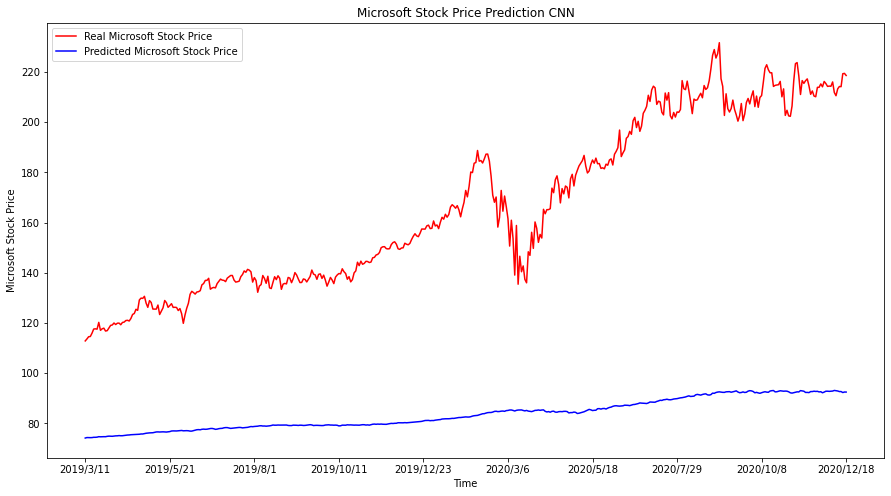

In [22]:

predicted_stock_price = model.predict(X_test).reshape(-1,1)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)
y =  dataset_test.values.reshape(451,) 
x = df.loc[1052: , "Date"] 
# Visualising the results
plt.figure(figsize=(15,8))
plt.plot(x, y, c= "red", label = "Real Microsoft Stock Price")
plt.plot(df.loc[1052:, "Date"],predicted_stock_price, color = "blue", label = "Predicted Microsoft Stock Price")
plt.xticks(np.arange(0,451,50))
plt.title('Microsoft Stock Price Prediction CNN')
plt.xlabel('Time')
plt.ylabel('Microsoft Stock Price')
plt.legend()
plt.savefig("Microsoft CNN")
plt.show() 

In [23]:
abse = mean_absolute_error(predicted_stock_price,y)
abse

82.76391321431215

In [24]:
rmse=math.sqrt(mean_squared_error(predicted_stock_price,y))
rmse

87.3247493977504

LSTM GRU MODEL

In [25]:

# Creating a data structure with 60 time-steps and 1 output
X_train = []
y_train = []
for i in range(60, 1052):
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0],  X_train.shape[1], 1))
X_train.shape

(992, 60, 1)

In [26]:
np.random.seed(1)
model = Sequential()
model.add(LSTM(units = 700, return_sequences=True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.1))
model.add(GRU(units = 700,  input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.1))
model.add(Dense(units = 1))
model.compile(optimizer = 'adam', loss = 'mean_squared_error')
model.fit(X_train, y_train, epochs = 30, batch_size = 32)

Epoch 1/30
31/31 [==============================] - 3s 31ms/step - loss: 0.0102
Epoch 2/30
31/31 [==============================] - 1s 30ms/step - loss: 0.0012
Epoch 3/30
31/31 [==============================] - 1s 30ms/step - loss: 7.6370e-04
Epoch 4/30
31/31 [==============================] - 1s 31ms/step - loss: 8.4322e-04
Epoch 5/30
31/31 [==============================] - 1s 31ms/step - loss: 8.0723e-04
Epoch 6/30
31/31 [==============================] - 1s 30ms/step - loss: 0.0011
Epoch 7/30
31/31 [==============================] - 1s 30ms/step - loss: 7.8321e-04
Epoch 8/30
31/31 [==============================] - 1s 30ms/step - loss: 5.1241e-04
Epoch 9/30
31/31 [==============================] - 1s 30ms/step - loss: 6.1005e-04
Epoch 10/30
31/31 [==============================] - 1s 30ms/step - loss: 6.8169e-04
Epoch 11/30
31/31 [==============================] - 1s 31ms/step - loss: 4.3518e-04
Epoch 12/30
31/31 [==============================] - 1s 30ms/step - loss: 5.4100e-04
E

TEST DATA

In [27]:
# Getting the predicted stock price of 2017
dataset_train = df.iloc[:1052, 4:5]
dataset_test = df.iloc[1052:, 4:5]
dataset_total = pd.concat((dataset_train, dataset_test), axis = 0)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 60:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
print(inputs.shape)
X_test = []
for i in range(60, 511):
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
print(X_test.shape)


(511, 1)
(451, 60, 1)


PREDICTION

<function matplotlib.pyplot.show>

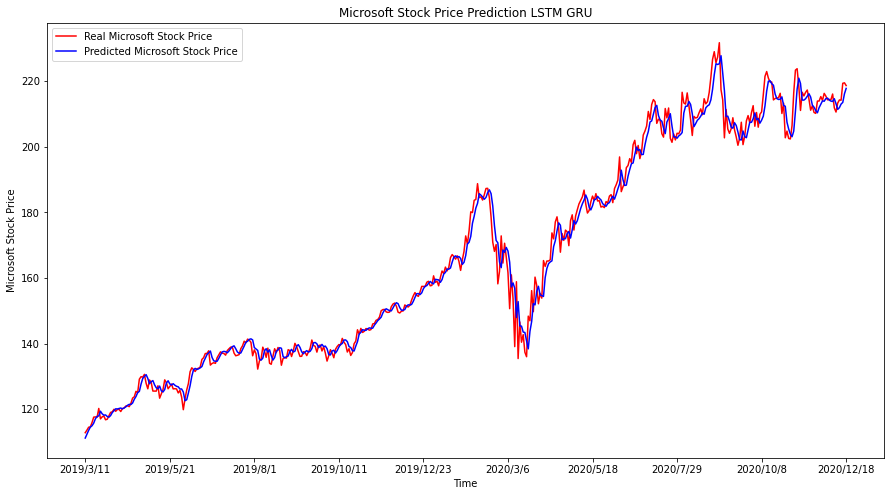

In [28]:
predicted_stock_price = model.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)
y =  dataset_test.values.reshape(451,) 
x = df.loc[1052: , "Date"] 
# Visualising the results
plt.figure(figsize=(15,8))
plt.plot(x, y, c= "red", label = "Real Microsoft Stock Price")
plt.plot(df.loc[1052:, "Date"],predicted_stock_price, color = "blue", label = "Predicted Microsoft Stock Price")
plt.xticks(np.arange(0,451,50))
plt.title('Microsoft Stock Price Prediction LSTM GRU')
plt.xlabel('Time')
plt.ylabel('Microsoft Stock Price')
plt.legend() 
plt.savefig("Microsoft LSTM GRU")
plt.show

In [29]:
abse = mean_absolute_error(predicted_stock_price,y)
abse

2.4491196598314513

In [30]:
rmse = math.sqrt(mean_squared_error(predicted_stock_price,y))
rmse

3.6328256743250926

LSTM Model

In [31]:
model = Sequential()

model.add(LSTM(units = 700, input_shape = (X_train.shape[1], 1))) 
model.add(Dropout(0.1))

model.add(Dense(units = 1))


model.compile(optimizer = 'adam', loss = 'mean_squared_error')


model.fit(X_train, y_train, epochs = 30, batch_size = 32)

Epoch 1/30
31/31 [==============================] - 2s 17ms/step - loss: 0.0511
Epoch 2/30
31/31 [==============================] - 0s 16ms/step - loss: 0.0032
Epoch 3/30
31/31 [==============================] - 0s 16ms/step - loss: 7.4413e-04
Epoch 4/30
31/31 [==============================] - 0s 16ms/step - loss: 6.9626e-04
Epoch 5/30
31/31 [==============================] - 0s 16ms/step - loss: 6.6533e-04
Epoch 6/30
31/31 [==============================] - 0s 16ms/step - loss: 7.0265e-04
Epoch 7/30
31/31 [==============================] - 0s 16ms/step - loss: 7.9293e-04
Epoch 8/30
31/31 [==============================] - 0s 16ms/step - loss: 6.6920e-04
Epoch 9/30
31/31 [==============================] - 0s 16ms/step - loss: 6.4977e-04
Epoch 10/30
31/31 [==============================] - 0s 16ms/step - loss: 6.1989e-04
Epoch 11/30
31/31 [==============================] - 0s 15ms/step - loss: 6.4246e-04
Epoch 12/30
31/31 [==============================] - 0s 16ms/step - loss: 6.7324e-

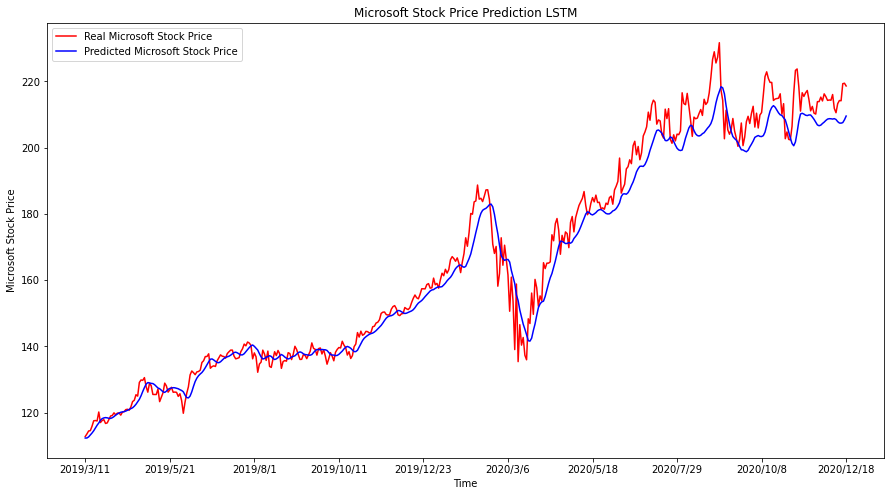

In [32]:
predicted_stock_price = model.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)
y =  dataset_test.values.reshape(451,) 
x = df.loc[1052: , "Date"] 
# Visualising the results
plt.figure(figsize=(15,8))
plt.plot(x, y, c= "red", label = "Real Microsoft Stock Price")
plt.plot(df.loc[1052:, "Date"],predicted_stock_price, color = "blue", label = "Predicted Microsoft Stock Price")
plt.xticks(np.arange(0,451,50))
plt.title('Microsoft Stock Price Prediction LSTM')
plt.xlabel('Time')
plt.ylabel('Microsoft Stock Price')
plt.legend()
plt.savefig("Microsoft LSTM")
plt.show() 

In [33]:
abse = mean_absolute_error(predicted_stock_price,y)
abse

4.220437440090814

In [34]:
rmse = math.sqrt(mean_squared_error(predicted_stock_price,y))
rmse

5.824560901033376

RNN MODEL


In [35]:
model = Sequential()

model.add(SimpleRNN(units = 700, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))

model.add(Dense(units = 1))

model.compile(optimizer = 'adam', loss = 'mean_squared_error')

model.fit(X_train, y_train, epochs = 30, batch_size = 32) 

Epoch 1/30
31/31 [==============================] - 2s 28ms/step - loss: 0.5770
Epoch 2/30
31/31 [==============================] - 1s 29ms/step - loss: 0.2411
Epoch 3/30
31/31 [==============================] - 1s 28ms/step - loss: 0.1157
Epoch 4/30
31/31 [==============================] - 1s 28ms/step - loss: 0.1334
Epoch 5/30
31/31 [==============================] - 1s 29ms/step - loss: 0.0932
Epoch 6/30
31/31 [==============================] - 1s 29ms/step - loss: 0.7889
Epoch 7/30
31/31 [==============================] - 1s 28ms/step - loss: 0.7986
Epoch 8/30
31/31 [==============================] - 1s 28ms/step - loss: 0.4775
Epoch 9/30
31/31 [==============================] - 1s 30ms/step - loss: 0.4787
Epoch 10/30
31/31 [==============================] - 1s 29ms/step - loss: 0.4229
Epoch 11/30
31/31 [==============================] - 1s 29ms/step - loss: 0.3971
Epoch 12/30
31/31 [==============================] - 1s 28ms/step - loss: 0.4117
Epoch 13/30
31/31 [==================

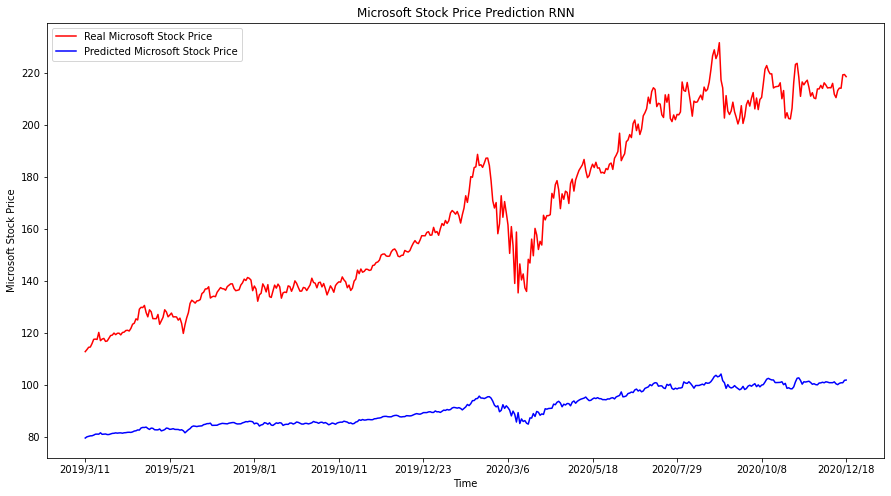

In [36]:
predicted_stock_price = model.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)
y =  dataset_test.values.reshape(451,) 
x = df.loc[1052: , "Date"] 
# Visualising the results
plt.figure(figsize=(15,8))
plt.plot(x, y, c= "red", label = "Real Microsoft Stock Price")
plt.plot(df.loc[1052:, "Date"],predicted_stock_price, color = "blue", label = "Predicted Microsoft Stock Price")
plt.xticks(np.arange(0,451,50))
plt.title('Microsoft Stock Price Prediction RNN')
plt.xlabel('Time')
plt.ylabel('Microsoft Stock Price')
plt.legend()
plt.savefig("Microsoft RNN")
plt.show() 

In [37]:
abse = mean_absolute_error(predicted_stock_price,y)
abse

75.20727230172966

In [38]:
rmse = math.sqrt(mean_squared_error(predicted_stock_price,y))
rmse

79.79958346837965

GRU

In [39]:
np.random.seed(1)

model = Sequential()

model.add(GRU(units = 700, input_shape = (X_train.shape[1], 1))) 

model.add(Dropout(0.2))

model.add(Dense(units = 1))

model.compile(optimizer = 'adam', loss = 'mean_squared_error')


model.fit(X_train, y_train, epochs = 30, batch_size = 32)

Epoch 1/30
31/31 [==============================] - 2s 14ms/step - loss: 0.0173
Epoch 2/30
31/31 [==============================] - 0s 14ms/step - loss: 8.6278e-04
Epoch 3/30
31/31 [==============================] - 0s 13ms/step - loss: 5.5526e-04
Epoch 4/30
31/31 [==============================] - 0s 14ms/step - loss: 5.3401e-04
Epoch 5/30
31/31 [==============================] - 0s 14ms/step - loss: 5.2027e-04
Epoch 6/30
31/31 [==============================] - 0s 14ms/step - loss: 5.5453e-04
Epoch 7/30
31/31 [==============================] - 0s 13ms/step - loss: 5.9408e-04
Epoch 8/30
31/31 [==============================] - 0s 13ms/step - loss: 5.6049e-04
Epoch 9/30
31/31 [==============================] - 0s 13ms/step - loss: 5.7582e-04
Epoch 10/30
31/31 [==============================] - 0s 13ms/step - loss: 5.7066e-04
Epoch 11/30
31/31 [==============================] - 0s 13ms/step - loss: 5.0450e-04
Epoch 12/30
31/31 [==============================] - 0s 13ms/step - loss: 6.43

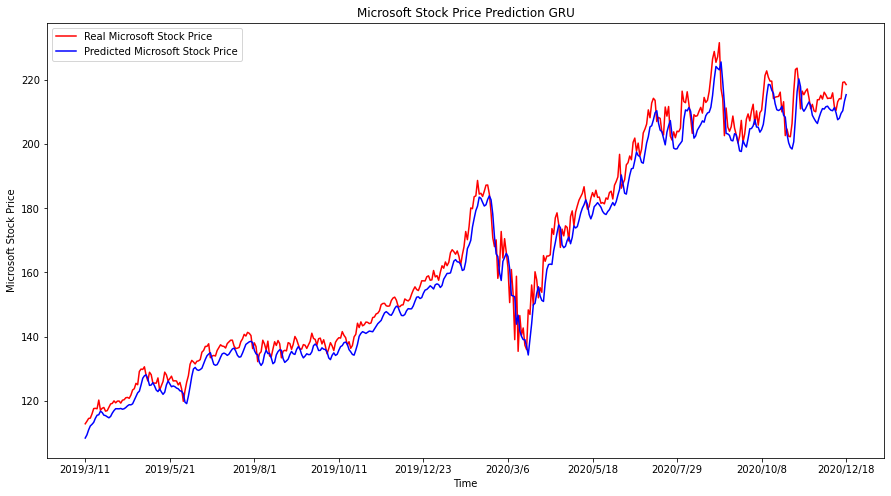

In [40]:

predicted_stock_price = model.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)
y =  dataset_test.values.reshape(451,) 
x = df.loc[1052: , "Date"] 
# Visualising the results
plt.figure(figsize=(15,8))
plt.plot(x, y, c= "red", label = "Real Microsoft Stock Price")
plt.plot(df.loc[1052:, "Date"],predicted_stock_price, color = "blue", label = "Predicted Microsoft Stock Price")
plt.xticks(np.arange(0,451,50))
plt.title('Microsoft Stock Price Prediction GRU')
plt.xlabel('Time')
plt.ylabel('Microsoft Stock Price')
plt.legend() 
plt.savefig("Microsoft GRU")
plt.show()

In [41]:
abse = mean_absolute_error(predicted_stock_price,y)
abse

4.035376970493089

In [42]:
rmse = math.sqrt(mean_squared_error(predicted_stock_price,y))
rmse

4.90168674491996

Bi-LSTM

In [43]:
np.random.seed(1)
model = Sequential()

model.add(Bidirectional(LSTM(units = 700, input_shape = (X_train.shape[1], 1)))) 
model.add(Dropout(0.1))

model.add(Dense(units = 1))


model.compile(optimizer = 'adam', loss = 'mean_squared_error')


model.fit(X_train, y_train, epochs = 30, batch_size = 32)

Epoch 1/30
31/31 [==============================] - 4s 30ms/step - loss: 0.0391
Epoch 2/30
31/31 [==============================] - 1s 30ms/step - loss: 0.0017
Epoch 3/30
31/31 [==============================] - 1s 30ms/step - loss: 0.0012
Epoch 4/30
31/31 [==============================] - 1s 31ms/step - loss: 0.0013
Epoch 5/30
31/31 [==============================] - 1s 31ms/step - loss: 0.0011
Epoch 6/30
31/31 [==============================] - 1s 31ms/step - loss: 9.3533e-04
Epoch 7/30
31/31 [==============================] - 1s 31ms/step - loss: 0.0010
Epoch 8/30
31/31 [==============================] - 1s 30ms/step - loss: 9.0542e-04
Epoch 9/30
31/31 [==============================] - 1s 30ms/step - loss: 8.9146e-04
Epoch 10/30
31/31 [==============================] - 1s 30ms/step - loss: 0.0010
Epoch 11/30
31/31 [==============================] - 1s 30ms/step - loss: 9.2630e-04
Epoch 12/30
31/31 [==============================] - 1s 30ms/step - loss: 8.0637e-04
Epoch 13/30
31/31

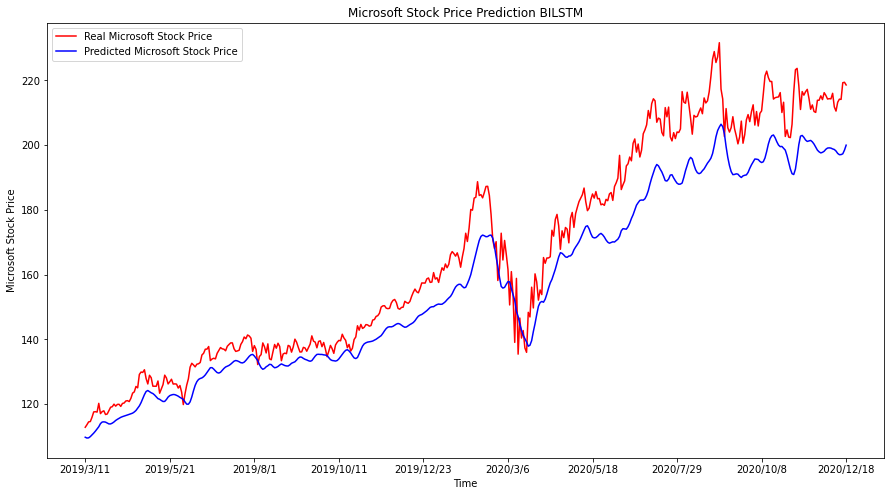

In [44]:

predicted_stock_price = model.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)
y =  dataset_test.values.reshape(451,) 
x = df.loc[1052: , "Date"] 
# Visualising the results
plt.figure(figsize=(15,8))
plt.plot(x, y, c= "red", label = "Real Microsoft Stock Price")
plt.plot(df.loc[1052:, "Date"],predicted_stock_price, color = "blue", label = "Predicted Microsoft Stock Price")
plt.xticks(np.arange(0,451,50))
plt.title('Microsoft Stock Price Prediction BILSTM')
plt.xlabel('Time')
plt.ylabel('Microsoft Stock Price')
plt.legend()
plt.savefig("Microsoft BILSTM")
plt.show() 

In [45]:
abse = mean_absolute_error(predicted_stock_price,y)
abse

9.87467945144254

In [46]:
rmse = math.sqrt(mean_squared_error(predicted_stock_price,y))
rmse

11.690166802705479

Bi-GRU

In [47]:
model = Sequential()

model.add(Bidirectional(GRU(units = 700, input_shape = (X_train.shape[1], 1))))
model.add(Dropout(0.1))

model.add(Dense(units = 1))

model.compile(optimizer = 'adam', loss = 'mean_squared_error')


model.fit(X_train, y_train, epochs = 30, batch_size = 32)

Epoch 1/30
31/31 [==============================] - 4s 27ms/step - loss: 0.0142
Epoch 2/30
31/31 [==============================] - 1s 26ms/step - loss: 0.0016
Epoch 3/30
31/31 [==============================] - 1s 26ms/step - loss: 0.0011
Epoch 4/30
31/31 [==============================] - 1s 26ms/step - loss: 8.7689e-04
Epoch 5/30
31/31 [==============================] - 1s 26ms/step - loss: 7.4764e-04
Epoch 6/30
31/31 [==============================] - 1s 26ms/step - loss: 6.9612e-04
Epoch 7/30
31/31 [==============================] - 1s 27ms/step - loss: 6.3562e-04
Epoch 8/30
31/31 [==============================] - 1s 26ms/step - loss: 7.4534e-04
Epoch 9/30
31/31 [==============================] - 1s 26ms/step - loss: 7.5848e-04
Epoch 10/30
31/31 [==============================] - 1s 26ms/step - loss: 8.3726e-04
Epoch 11/30
31/31 [==============================] - 1s 27ms/step - loss: 6.8893e-04
Epoch 12/30
31/31 [==============================] - 1s 26ms/step - loss: 4.4935e-04
E

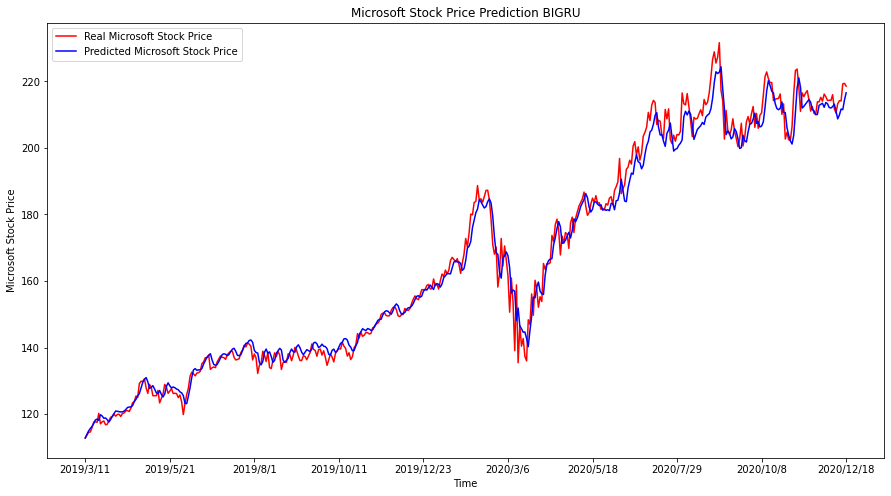

In [48]:
predicted_stock_price = model.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)
y =  dataset_test.values.reshape(451,) 
x = df.loc[1052: , "Date"] 
# Visualising the results
plt.figure(figsize=(15,8))
plt.plot(x, y, c= "red", label = "Real Microsoft Stock Price")
plt.plot(df.loc[1052:, "Date"],predicted_stock_price, color = "blue", label = "Predicted Microsoft Stock Price")
plt.xticks(np.arange(0,451,50))
plt.title('Microsoft Stock Price Prediction BIGRU')
plt.xlabel('Time')
plt.ylabel('Microsoft Stock Price')
plt.legend() 
plt.savefig("Microsoft BIGRU")
plt.show()

In [49]:
abse = mean_absolute_error(predicted_stock_price,y)
abse

2.7715624806722903

In [50]:
rmse = math.sqrt(mean_squared_error(predicted_stock_price,y))
rmse

3.917990549410099

Breaking Dataset to Improve Performance

In [51]:
training_set = df.iloc[:, 4:5].values
# Feature Scaling
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)
# Creating a data structure with 60 time-steps and 1 output




In [52]:
X_train = []
y_train = []
for i in range(60, 351):
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i, 0])

for i in range(501, 852):
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i, 0])

for i in range(1002, 1353):
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0],  X_train.shape[1], 1))
X_train.shape

(993, 60, 1)

In [53]:

inputs = df.iloc[:, 4:5].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
print(inputs.shape)




(1503, 1)


In [54]:
X_test = []
y_test = []
for i in range(351, 501):
    X_test.append(inputs[i-60:i, 0])
    y_test.append(df.iloc[i, 4:5].values)

for i in range(852, 1002):
    X_test.append(inputs[i-60:i, 0])
    y_test.append(df.iloc[i, 4:5].values)

for i in range(1353, 1503):
    X_test.append(inputs[i-60:i, 0])
    y_test.append(df.iloc[i, 4:5].values)

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
print(X_test.shape)
# (459, 60, 1)

(450, 60, 1)


In [55]:
np.random.seed(1)

model = Sequential()

model.add(GRU(units = 700, input_shape = (X_train.shape[1], 1))) 

model.add(Dropout(0.2))

model.add(Dense(units = 1))


model.compile(optimizer = 'adam', loss = 'mean_squared_error')


model.fit(X_train, y_train, epochs = 30, batch_size = 32)

Epoch 1/30
32/32 [==============================] - 2s 17ms/step - loss: 0.0078
Epoch 2/30
32/32 [==============================] - 0s 14ms/step - loss: 5.0145e-04
Epoch 3/30
32/32 [==============================] - 0s 14ms/step - loss: 2.6870e-04
Epoch 4/30
32/32 [==============================] - 0s 14ms/step - loss: 2.3767e-04
Epoch 5/30
32/32 [==============================] - 0s 14ms/step - loss: 2.4721e-04
Epoch 6/30
32/32 [==============================] - 0s 14ms/step - loss: 2.2164e-04
Epoch 7/30
32/32 [==============================] - 0s 14ms/step - loss: 2.6621e-04
Epoch 8/30
32/32 [==============================] - 0s 14ms/step - loss: 2.5878e-04
Epoch 9/30
32/32 [==============================] - 0s 14ms/step - loss: 2.4189e-04
Epoch 10/30
32/32 [==============================] - 0s 14ms/step - loss: 3.4116e-04
Epoch 11/30
32/32 [==============================] - 0s 14ms/step - loss: 2.1447e-04
Epoch 12/30
32/32 [==============================] - 0s 14ms/step - loss: 2.69

In [56]:

predicted_stock_price = model.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)


In [57]:
abse = mean_absolute_error(predicted_stock_price, y_test)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py:96: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  y_pred = check_array(y_pred, ensure_2d=False, dtype=dtype)


In [58]:
abse

2.6204643275482855

In [59]:
rmse = math.sqrt(mean_squared_error(predicted_stock_price,y_test))
rmse

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py:96: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  y_pred = check_array(y_pred, ensure_2d=False, dtype=dtype)


3.658729070771157

In [60]:
x1 = df.loc[351:500 , "Date"]
x2 = df.loc[852:1001 , "Date"]
x3 = df.loc[1353: , "Date"]

In [61]:
x = pd.concat([x1,x2,x3], axis =0)

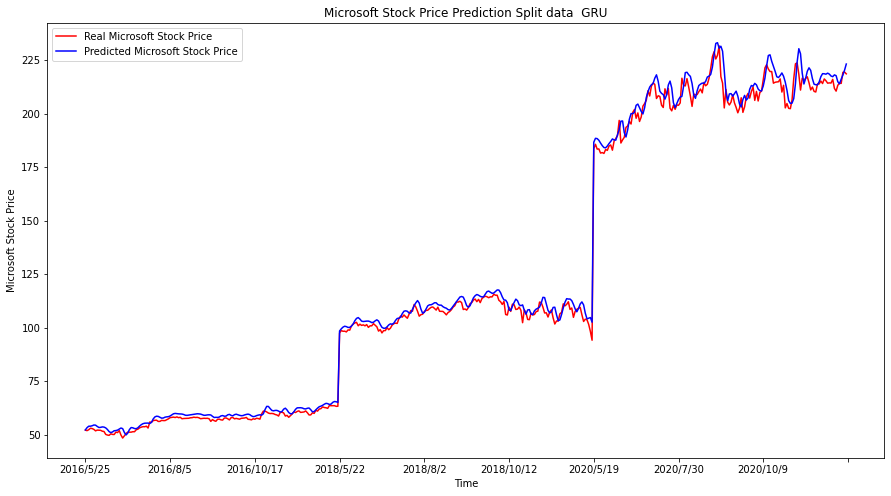

In [62]:

# Visualising the results
plt.figure(figsize=(15,8))
plt.plot(x, y_test, c= "red", label = "Real Microsoft Stock Price")
plt.plot(x,predicted_stock_price, color = "blue", label = "Predicted Microsoft Stock Price")
plt.xticks(np.arange(0,451,50))
plt.title('Microsoft Stock Price Prediction Split data  GRU')
plt.xlabel('Time')
plt.ylabel('Microsoft Stock Price')
plt.legend() 
plt.savefig("Microsoft Split data GRU")
plt.show()